In [1]:
# import libraries and set up the molecule geometry

from ase.units import Ry, eV, Ha
from ase.calculators.siesta import Siesta
from ase import Atoms
import numpy as np
import matplotlib.pyplot as plt

H2O = Atoms('H2O', positions = [[-0.757,  0.586,  0.000],
                                [0.757,  0.586,  0.000],
                                [0.0, 0.0, 0.0]],
            cell=[20, 20, 20])

# visualization of the particle
from ase.visualize import view
view(H2O, viewer='x3d')

In [2]:
# enter siesta input and run siesta
siesta = Siesta(
    mesh_cutoff=150 * Ry,
    basis_set='DZP',
    pseudo_qualifier='lda',
    energy_shift=(10 * 10**-3) * eV,
    fdf_arguments={
        'SCFMustConverge': False,
        'COOP.Write': True,
        'WriteDenchar': True,
        'PAO.BasisType': 'split',
        'DM.Tolerance': 1e-4,
        'DM.MixingWeight': 0.01,
        'MaxSCFIterations': 300,
        'DM.NumberPulay': 4,
        'XML.Write': True})

H2O.set_calculator(siesta)
e = H2O.get_potential_energy()

In [3]:
# compute polarizability using pyscf-nao

freq, noninpol, pol = siesta.get_polarizability_pyscf_inter(label="siesta", jcutoff=7, iter_broadening=0.15/Ha,
        xc_code='LDA,PZ', tol_loc=1e-6, tol_biloc=1e-7, freq = np.arange(0.0, 15.0, 0.05))

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


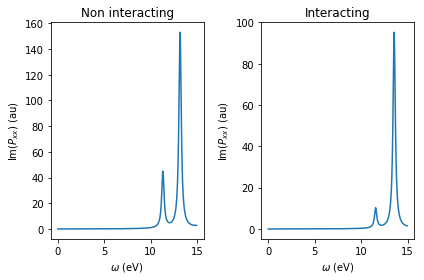

In [4]:
# plot polarizability with matplotlib

fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(freq, noninpol[:, 0, 0].imag)
ax2.plot(freq, pol[:, 0, 0].imag)

ax1.set_xlabel(r"$\omega$ (eV)")
ax2.set_xlabel(r"$\omega$ (eV)")

ax1.set_ylabel(r"Im($P_{xx}$) (au)")
ax2.set_ylabel(r"Im($P_{xx}$) (au)")

ax1.set_title(r"Non interacting")
ax2.set_title(r"Interacting")

fig.tight_layout()

In [5]:
# Even better with plotly

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools


py.init_notebook_mode(connected=True)

fig_plotly = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]],
         subplot_titles=('Non interacting', 'interacting'))

fig_plotly.append_trace(go.Scatter(x=freq,
                y=noninpol[:, 0, 0].imag, name="Non interacting",
                mode = "lines",
                line=dict(color="blue", width=3)), 1, 1)

fig_plotly.append_trace(go.Scatter(x=freq,
                y=pol[:, 0, 0].imag, name="interacting",
                mode = "lines",
                line=dict(color="red", width=3)), 1, 2)

fig_plotly['layout']['xaxis1'].update(title='Energy (eV)', titlefont={'size': 25}, tickfont={'size': 17})
fig_plotly['layout']['xaxis2'].update(title='Energy (eV)', titlefont={'size': 25}, tickfont={'size': 17})

fig_plotly['layout']['yaxis1'].update(title='Im(Pxx) (eV)', titlefont={'size': 25}, tickfont={'size': 17})

py.iplot(fig_plotly, filename='pol_h2o.html')

ModuleNotFoundError: No module named 'plotly'